# Homework 09

In this homework, we'll deploy the bees vs wasps model we trained in the 
[previous homework](../08-deep-learning/homework.md).

Download the model from here: 

https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5

In [37]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.13.1'

In [38]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input

In [39]:
MODEL_FILEPATH = "bees-wasps.h5"
MODEL_LITE_FILEPATH = "bees-wasps.tflite"

## Question 1

Now convert this model from Keras to TF-Lite format.

What's the size of the **converted** model?

* 21 Mb
* **43 Mb** (answer)
* 80 Mb
* 164 Mb

In [40]:
model = keras.models.load_model(MODEL_FILEPATH)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open(MODEL_LITE_FILEPATH, 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp6nn1xakk/assets


INFO:tensorflow:Assets written to: /tmp/tmp6nn1xakk/assets
2024-12-13 23:37:48.695899: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-12-13 23:37:48.696093: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-12-13 23:37:48.697668: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6nn1xakk
2024-12-13 23:37:48.705437: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-12-13 23:37:48.705578: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp6nn1xakk
2024-12-13 23:37:48.734396: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-12-13 23:37:49.435169: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp6nn1xakk
2024-12-13 23:37:49.549872: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

In [41]:
import os

file_stats = os.stat(MODEL_LITE_FILEPATH)
print(file_stats)
print(f'File Size in Bytes is {file_stats.st_size}')

os.stat_result(st_mode=33204, st_ino=3200024, st_dev=66309, st_nlink=1, st_uid=1000, st_gid=1000, st_size=44866200, st_atime=1733941176, st_mtime=1734151075, st_ctime=1734151075)
File Size in Bytes is 44866200


## Question 2

To be able to use this model, we need to know the index of the input and 
the index of the output. 

What's the output index for this model?

* 3
* 7
* **13** (answer)
* 24

In [42]:
import tensorflow.lite as tflite

interpreter = tflite.Interpreter(model_path=MODEL_LITE_FILEPATH)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [43]:
print("output index", output_index)

output index 13


## Preparing the image

You'll need some code for downloading and resizing images. You can use 
this code:

```python
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img
```

For that, you'll need to have `pillow` installed:

```bash
pip install pillow
```

Let's download and resize this image: 

https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

Based on the previous homework, what should be the target size for the image?

In [44]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

In [45]:
IMAGE_URL =  "https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg"

img = download_image(IMAGE_URL)
img_resized = prepare_image(img, (150, 150))

In [54]:
import matplotlib.pyplot as plt 

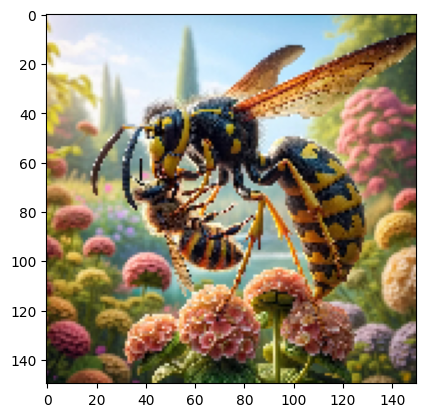

In [56]:
plt.imshow(img_resized)
plt.show()

In [57]:
def preprocess_input_numpy(X):
    temp_array = np.array(X, dtype=np.float32)
    temp_array = (temp_array / 255.0 * 2) - 1
    return temp_array

    

## Question 3

Now we need to turn the image into numpy array and pre-process it. 

> Tip: Check the previous homework. What was the pre-processing 
> we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

* 0.3450980
* 0.5450980
* 0.7450980
* 0.9450980

In [46]:
x = np.array(img_resized)
X = np.array([x])

X = preprocess_input(X)

In [47]:
X[0][0][0]

array([0.8901961 , 0.81960785, 0.7019608 ], dtype=float32)

In [63]:
type(X)

numpy.ndarray

In [60]:
Y = preprocess_input_numpy(np.array([x]))

In [61]:
Y[0][0][0]

array([0.8901961 , 0.81960785, 0.7019608 ], dtype=float32)

In [62]:
np.sum(np.square(X - Y))

0.0

## Question 4

Now let's apply this model to this image. What's the output of the model?

* 0.258
* 0.458
* 0.658
* 0.858

In [48]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [49]:
preds

array([[0.14101154]], dtype=float32)

## Prepare the lambda code 

Now you need to copy all the code into a separate python file. You will 
need to use this file for the next two questions.

Tip: you can test this file locally with `ipython` or Jupyter Notebook 
by importing the file and invoking the function from this file.

## Docker 

For the next two questions, we'll use a Docker image that we already 
prepared. This is the Dockerfile that we used for creating the image:

```docker
FROM public.ecr.aws/lambda/python:3.10
COPY bees-wasps-v2.tflite .
```

And pushed it to [`agrigorev/zoomcamp-bees-wasps:v2`](https://hub.docker.com/r/agrigorev/zoomcamp-bees-wasps/tags).

A few notes:

* The image already contains a model and it's not the same model
  as the one we used for questions 1-4.
* The version of Python is 3.10, so you need to use the right wheel for 
  TF-Lite. For Tensorflow 2.14.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.14.0-cp310-cp310-linux_x86_64.whl

## Question 5

Download the base image `agrigorev/zoomcamp-bees-wasps:v2`. You can easily make it by using [docker pull](https://docs.docker.com/engine/reference/commandline/pull/) command.

So what's the size of this base image?

* 162 Mb
* 362 Mb
* **662 Mb** (answer)
* 962 Mb

You can get this information when running `docker images` - it'll be in the "SIZE" column.


```bash
$ docker image ls | grep agrigorev 
agrigorev/zoomcamp-bees-wasps            v2            b9f6c13de368   12 months ago   662MB
```

## Question 6

Now let's extend this docker image, install all the required libraries
and add the code for lambda.

You don't need to include the model in the image. It's already included. 
The name of the file with the model is `bees-wasps-v2.tflite` and it's 
in the current workdir in the image (see the Dockerfile above for the 
reference). 
The provided model requires the same preprocessing for images regarding target size and rescaling the value range than used in homework 8.

Now run the container locally.

Score this image: https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

What's the output from the model?

* 0.2453
* 0.4453
* 0.6453
* 0.8453

In [50]:
import requests

url = 'http://localhost:8080/2015-03-31/functions/function/invocations'

data = {'url': 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'}

result = requests.post(url, json=data).json()
print(result)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)


## Publishing it to AWS

Now you can deploy your model to AWS!

* Publish your image to ECR
* Create a lambda function in AWS, use the ECR image
* Give it more RAM and increase the timeout 
* Test it
* Expose the lambda function using API Gateway

This is optional and not graded.

## Publishing to Docker hub

This is just for reference, this is how we published our image to Docker hub:

```bash
docker build -t zoomcamp-bees-wasps -f homework.dockerfile .
docker tag zoomcamp-bees-wasps:latest agrigorev/zoomcamp-bees-wasps:v2
docker push agrigorev/zoomcamp-bees-wasps:v2
```

## Submit the results

* Submit your results here: TBA
* If your answer doesn't match options exactly, select the closest one